# ML Case Study 5

### Predict whether a loan applicant will default or repay the loan based on applicant details, financial data, and credit history.

In [28]:
!pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   -------------- ------------------------- 0.5/1.5 MB 335.7 kB/s eta 0:00:03
   -------------- ------------------------- 0.5/1.5 MB 335.7 kB/s eta 0:00:03
   -------------- ------------------------- 0.5/1.5 MB 335.7 kB/s eta 0:00:03
   -------------- ------------------------- 0.5/1.5 MB 335.7 kB/s eta 0:00:03
   --------------------- ------------------ 0.8/1.5 MB 342.4 kB/s eta 0:00:02
   ---------------------------- ----------- 1.0/1.5 MB 419.4 kB/s eta 0:00:01
   ---------------------------------------- 1.5/1


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: C:\Users\ASUS\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import lightgbm as lgb

In [34]:
url = "https://datascienceuwl.github.io/Project2018/loans50k.csv"
df = pd.read_csv(url, encoding='latin1')
print(df.head())    

   loanID   amount        term  rate  payment grade          employment  \
0  188861   8000.0   36 months  0.14   272.07     C       Warehouseman    
1  517703  11000.0   36 months  0.10   354.89     B      Vice President   
2  268587  35000.0   36 months  0.15  1220.33     D      Owner/Attorney   
3  579902  20000.0   60 months  0.12   447.83     C             Analyst   
4  617630  12000.0   60 months  0.12   266.88     B  medical technician   

      length      home    income  ...  totalBal totalRevLim accOpen24  \
0    3 years      RENT   49966.0  ...   48054.0      8100.0       8.0   
1  10+ years  MORTGAGE   50000.0  ...  265838.0     33400.0       4.0   
2  10+ years      RENT  360000.0  ...  850150.0     83000.0       2.0   
3    2 years  MORTGAGE   60000.0  ...   20671.0     14200.0       8.0   
4  10+ years  MORTGAGE   64000.0  ...  128034.0     14600.0       3.0   

     avgBal   bcOpen  bcRatio  totalLim  totalRevBal  totalBcLim  totalIlLim  
0    4369.0     43.0     95.7  

## Target Column

In [31]:
target_col_candidates = [col for col in df.columns if 'default' in col.lower() or 'status' in col.lower()]
target_col = target_col_candidates[0] if target_col_candidates else df.columns[-1]

## Handle Missing Values


In [32]:
df = df.dropna(subset=[target_col])
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].mean())

In [36]:
for col in ['Loan_Amount_Term']:  # add any other columns with similar issues
    if col in df.columns:
        df[col] = df[col].astype(str).str.extract('(\d+)').astype(float)

## Encoding Categorical Variables

In [38]:
cat_cols = df.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

## Splitting the Feature and Target

In [39]:
X = df.drop(columns=[target_col]).astype('float32')  # save memory
y = df[target_col].astype('int')


## Train Test Split

In [41]:
from collections import Counter

counts = Counter(y)
rare_classes = [cls for cls, cnt in counts.items() if cnt < 2]

if rare_classes:
    print(f"Removing rare classes with less than 2 samples: {rare_classes}")
    mask = ~y.isin(rare_classes)
    X = X[mask]
    y = y[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTraining set size:", X_train.shape)
print("Testing set size:", X_test.shape)
print("Target class distribution in training set:\n", Counter(y_train))


Removing rare classes with less than 2 samples: [7]

Training set size: (39999, 31)
Testing set size: (10000, 31)
Target class distribution in training set:
 Counter({3: 21659, 1: 11625, 0: 6063, 6: 359, 4: 209, 5: 82, 2: 2})


## Model Training

In [42]:
lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    max_depth=10,
    learning_rate=0.05,
    n_jobs=-1,
    random_state=42
)

lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4520
[LightGBM] [Info] Number of data points in the train set: 39999, number of used features: 31
[LightGBM] [Info] Start training from score -1.886650
[LightGBM] [Info] Start training from score -1.235697
[LightGBM] [Info] Start training from score -9.903463
[LightGBM] [Info] Start training from score -0.613433
[LightGBM] [Info] Start training from score -5.254275
[LightGBM] [Info] Start training from score -6.189890
[LightGBM] [Info] Start training from score -4.713287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,10
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


## Model Evaluation

In [46]:
y_pred = lgb_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Model Accuracy:", round(acc * 100, 2), "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", cm)


Model Accuracy: 89.87 %

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.90      0.93      1516
           1       0.86      0.84      0.85      2907
           2       0.00      0.00      0.00         0
           3       0.91      0.96      0.93      5415
           4       0.00      0.00      0.00        52
           5       0.00      0.00      0.00        20
           6       0.29      0.02      0.04        90

    accuracy                           0.90     10000
   macro avg       0.43      0.39      0.39     10000
weighted avg       0.89      0.90      0.89     10000


Confusion Matrix:
 [[1359   83    3   68    1    1    1]
 [  11 2439    2  452    0    0    3]
 [   0    0    0    0    0    0    0]
 [  14  193   12 5187    4    4    1]
 [   0   44    0    8    0    0    0]
 [   1   17    0    2    0    0    0]
 [  11   70    0    7    0    0    2]]


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731:

## Visualization

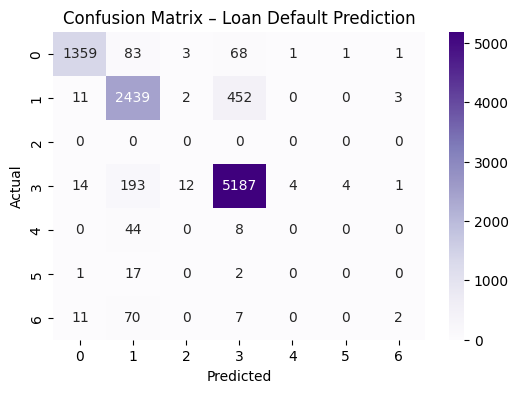

In [47]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title('Confusion Matrix – Loan Default Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Feature Importance

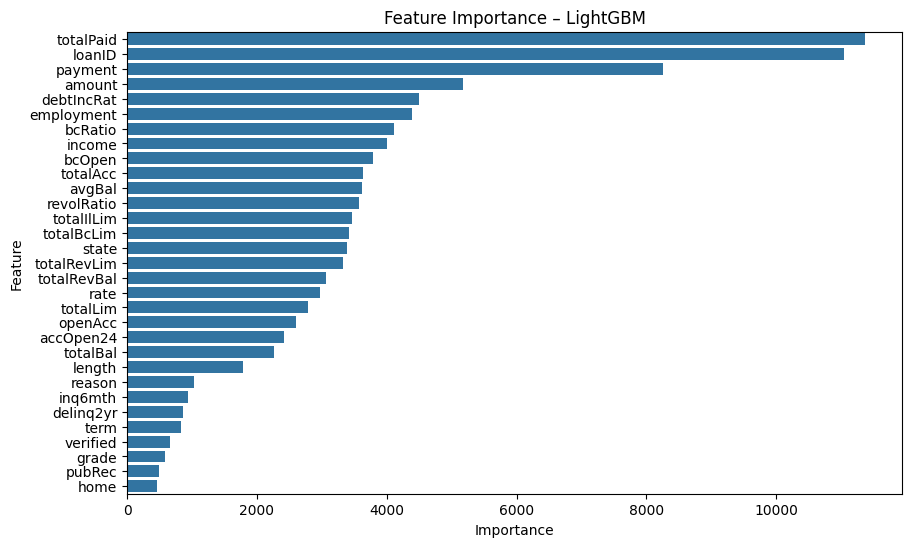

In [48]:
importances = lgb_model.feature_importances_
feat_imp = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp)
plt.title('Feature Importance – LightGBM')
plt.show()


## Hyperparamater Tuning

In [49]:
param_grid = {
    'n_estimators': [200, 500],
    'max_depth': [8, 10, 15],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [31, 50]
}

grid = GridSearchCV(lgb.LGBMClassifier(random_state=42),
                    param_grid,
                    cv=3,
                    scoring='accuracy',
                    n_jobs=-1)

grid.fit(X_train, y_train)

print("\nBest Parameters from GridSearchCV:", grid.best_params_)
best_model = grid.best_estimator_
best_pred = best_model.predict(X_test)
best_acc = accuracy_score(y_test, best_pred)

print("\nBest Tuned Model Accuracy:", round(best_acc * 100, 2), "%")

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


KeyboardInterrupt: 